### Import libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

import folium
from sklearn.cluster import KMeans

### Credentials for FourSquare API

In [2]:
CLIENT_ID='1XCUXXCEPR21OVC1PCPBR1OPI03GBMZZ4UQJ4Q4LFDQBHLDV'
CLIENT_SECRET='QQFPJ405NBNMY2IMJCSUGW5RWCNOB54M21N5GLPN34HPDTC4'
VERSION='20200513'
LIMIT=1000

GRAMADO_LAT=-29.387201
GRAMADO_LONG=-50.869473
RADIUS=4000

### Acquire data from FourSquare and store locally

In [ ]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, GRAMADO_LAT, GRAMADO_LONG, VERSION, RADIUS, LIMIT)
results = requests.get(url).json()
with open("data/foursquare_results1.json", "w") as outFile:
    json.dump(results, outFile)

### Retrieve local saved data from FourSquare

In [7]:
data_locations = None

with open("data/foursquare_results1.json", "r") as inFile:
    data_locations = json.load(inFile)

In [8]:
# Create an empty DataFrame
df_gramado = pd.DataFrame(data=None, columns=[])

# Populate the dataframe
for entry in data_locations['response']['groups'][0]['items']:
    try:
        address = entry['venue']['location']['address']
    except KeyError:
        address = "Not available"
        
    try:
        city = entry['venue']['location']['city']
    except KeyError:
        city = "Not available"
    
    data = pd.DataFrame({'Id': [entry['venue']['id']],
                         'Name': [entry['venue']['name']], 
                         'Address': [address],
                         'City': [city],
                         'Latitude': [entry['venue']['location']['lat']],
                         'Longitude': [entry['venue']['location']['lng']],
                         'Category': [entry['venue']['categories'][0]['name']]
                        })
    df_gramado = df_gramado.append(data)

In [9]:
df_gramado.head()
print("Total of locations: {}".format(df_gramado.shape[0]))

Total of locations: 100


### Display categories distribution

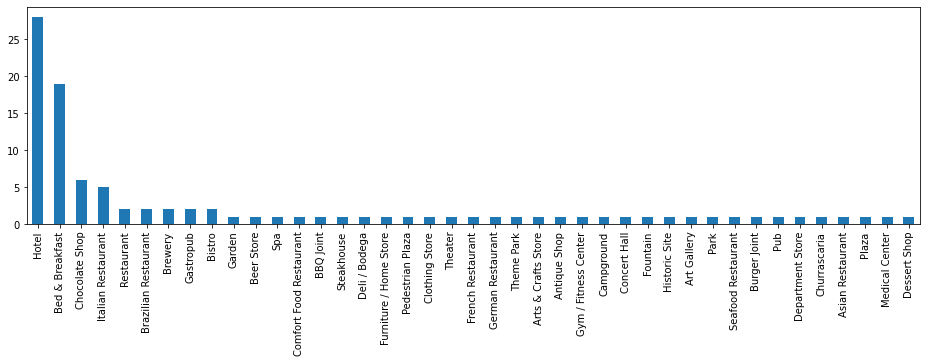

In [10]:
df_gramado['Category'].value_counts().plot(kind='bar', figsize=(16, 4))

### Complement dataframe with specific information for each place (ratings)

In [ ]:
df_gramadoTemp = pd.DataFrame(data=None, columns=[])

for id in df_gramado['Id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                id, CLIENT_ID, CLIENT_SECRET, VERSION, GRAMADO_LAT, GRAMADO_LONG, RADIUS, LIMIT)
    results = requests.get(url).json()
    
    try:
        rating = results['response']['venue']['rating']
    except KeyError:
        rating = -1
        
    df_gramadoTemp = df_gramadoTemp.append(pd.DataFrame({'Id': [id],
                                                         'Rating': [rating]
                                                        }))

In [ ]:
# Merge ratings for each place
df_gramado = pd.merge(left=df_gramado, right=df_gramadoTemp, left_on='Id', right_on='Id')
df_gramado

### Save location data with rating to local file

In [ ]:
df_gramado.to_csv("data/foursquare_results_ratings.json")

### Reload data from local file

In [11]:
df_gramado = pd.read_csv("data/foursquare_results_ratings.json")

# Discard places with no rating (-1 value)
print("Total of elements: {}".format(df_gramado.shape))
df_gramado = df_gramado[df_gramado['Rating']!= -1]
print("Total of elements with rating information: {}".format(df_gramado.shape))
df_gramado.head()

Total of elements: (100, 9)
Total of elements with rating information: (50, 9)


,Unnamed: 0,Id,Name,Address,City,Latitude,Longitude,Category,Rating
0,0,4c1edba263750f47476eba67,Pousada Ares da Serra,"R. Cel. João Corrêa, 214",Gramado,-29.384675,-50.871730,Bed & Breakfast,8.7
1,1,4c5da2f89b28d13a581f5a70,Residencial Pousada do Serrano,"R. Ângelo Bisol, 300",Gramado,-29.382232,-50.872580,Bed & Breakfast,9.2
2,2,4ccdcf4397d0224bb56f68b8,Kukos,"Av. Borges de Medeiros, 2123",Gramado,-29.383305,-50.872241,Antique Shop,8.8
3,3,4ea332a46da1455cacb27a31,Pão na Praça,Praça Mauricio Sirotsky Sobrinho,Gramado,-29.383375,-50.871813,Historic Site,8.7
4,4,4d48603d4c9ef04d58226a15,Hotel Ritta Höppner,"R. Pedro Candiago, 305",Gramado,-29.384665,-50.876159,Hotel,9.3


### Lets plot our places in Gramado into a Folium Map to have a general overview

<b>Red markers</b> signal Hotels and other places in same category

In [13]:
gramado_map = folium.Map(location=[GRAMADO_LAT, GRAMADO_LONG], zoom_start=14)

for lat, long, label, category in zip(df_gramado['Latitude'], df_gramado['Longitude'], df_gramado['Name'], df_gramado['Category']):
    label = folium.Popup(label + ", " + category, parse_html=True)
    
    if category in('Bed & Breakfast', 'Hotel'):
        fill_color='red'
    else:
        fill_color='blue'
    
    folium.CircleMarker([lat, long],
                       radius=5,
                       popup=label,
                       color=fill_color,
                       fill=True,
                       fill_opacity=0.7,
                       parse_html=False).add_to(gramado_map)

gramado_map

### Display categories distribution with rating information

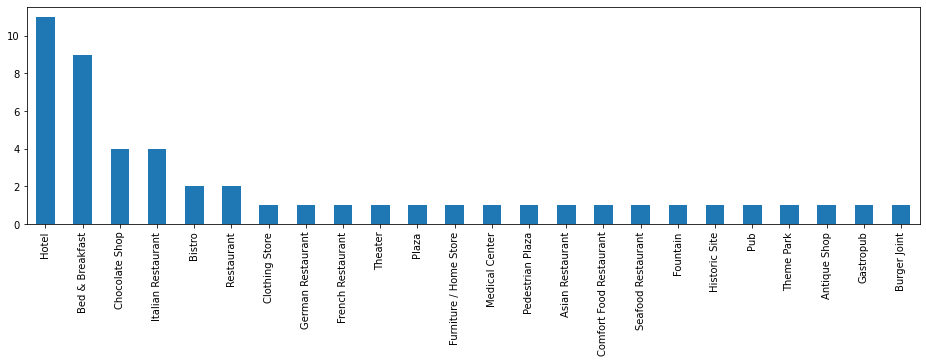

In [14]:
df_gramado['Category'].value_counts().plot(kind='bar', figsize=(16, 4))

### Create one-hot vector categories

In [21]:
df_one_hot = pd.get_dummies(df_gramado['Category'])
df_gramado_cat = pd.concat([df_gramado, df_one_hot], axis=1)
df_gramado_cat.head()

,Unnamed: 0,Id,Name,Address,City,Latitude,Longitude,Category,Rating,Antique Shop,...,Hotel,Italian Restaurant,Medical Center,Pedestrian Plaza,Plaza,Pub,Restaurant,Seafood Restaurant,Theater,Theme Park
0,0,4c1edba263750f47476eba67,Pousada Ares da Serra,"R. Cel. João Corrêa, 214",Gramado,-29.384675,-50.871730,Bed & Breakfast,8.7,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4c5da2f89b28d13a581f5a70,Residencial Pousada do Serrano,"R. Ângelo Bisol, 300",Gramado,-29.382232,-50.872580,Bed & Breakfast,9.2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,4ccdcf4397d0224bb56f68b8,Kukos,"Av. Borges de Medeiros, 2123",Gramado,-29.383305,-50.872241,Antique Shop,8.8,1,...,0,0,0,0,0,0,0,0,0,0
3,3,4ea332a46da1455cacb27a31,Pão na Praça,Praça Mauricio Sirotsky Sobrinho,Gramado,-29.383375,-50.871813,Historic Site,8.7,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4d48603d4c9ef04d58226a15,Hotel Ritta Höppner,"R. Pedro Candiago, 305",Gramado,-29.384665,-50.876159,Hotel,9.3,0,...,1,0,0,0,0,0,0,0,0,0


### Create 3 clusters by location and plot a map
We will use cluster centroids position as possible choices of places for the new Hotel

In [22]:
k = 4

df_gramado_k = df_gramado_cat[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=k, random_state=0).fit(df_gramado_k)

In [23]:
df_gramado_cat.insert(0, 'Cluster label', kmeans.labels_)
df_gramado_cat.head()

,Cluster label,Unnamed: 0,Id,Name,Address,City,Latitude,Longitude,Category,Rating,...,Hotel,Italian Restaurant,Medical Center,Pedestrian Plaza,Plaza,Pub,Restaurant,Seafood Restaurant,Theater,Theme Park
0,0,0,4c1edba263750f47476eba67,Pousada Ares da Serra,"R. Cel. João Corrêa, 214",Gramado,-29.384675,-50.871730,Bed & Breakfast,8.7,...,0,0,0,0,0,0,0,0,0,0
1,0,1,4c5da2f89b28d13a581f5a70,Residencial Pousada do Serrano,"R. Ângelo Bisol, 300",Gramado,-29.382232,-50.872580,Bed & Breakfast,9.2,...,0,0,0,0,0,0,0,0,0,0
2,0,2,4ccdcf4397d0224bb56f68b8,Kukos,"Av. Borges de Medeiros, 2123",Gramado,-29.383305,-50.872241,Antique Shop,8.8,...,0,0,0,0,0,0,0,0,0,0
3,0,3,4ea332a46da1455cacb27a31,Pão na Praça,Praça Mauricio Sirotsky Sobrinho,Gramado,-29.383375,-50.871813,Historic Site,8.7,...,0,0,0,0,0,0,0,0,0,0
4,2,4,4d48603d4c9ef04d58226a15,Hotel Ritta Höppner,"R. Pedro Candiago, 305",Gramado,-29.384665,-50.876159,Hotel,9.3,...,1,0,0,0,0,0,0,0,0,0


### Display map with clustering

In [38]:
gramado_map = folium.Map(location=[GRAMADO_LAT, GRAMADO_LONG], zoom_start=14)

fill_colors = ['red', 'green', 'blue', 'orange', 'darkpurple']

for lat, long, label, cluster_label in zip(df_gramado_cat['Latitude'], df_gramado_cat['Longitude'], df_gramado_cat['Name'], df_gramado_cat['Cluster label']):
    label = folium.Popup(label + " [{}]".format(cluster_label), parse_html=True)
     
    folium.CircleMarker([lat, long],
                       radius=5,
                       popup=label,
                       color=fill_colors[cluster_label],
                       fill=True,
                       fill_opacity=0.7,
                       parse_html=False).add_to(gramado_map)
    
for centroid, cluster_label in zip(kmeans.cluster_centers_, range(k + 1)):
    folium.Marker([centroid[0], centroid[1]],
                  icon=folium.Icon(color=fill_colors[cluster_label]),
                 ).add_to(gramado_map)

gramado_map

### Let's examine each cluster by number of places category and places rating average

In [39]:
def showClusterData(clabel):
    ratings = df_gramado_cat.loc[df_gramado_cat['Cluster label'] == clabel][['Category', 'Rating']].groupby('Category').mean().reset_index()
    count = df_gramado_cat.loc[df_gramado_cat['Cluster label'] == clabel].groupby('Category').count().reset_index()
    df_c = pd.concat([ratings[['Category', 'Rating']], count['Id']], axis=1).set_index('Category')
    df_c.columns = ['Rating', 'Total Places']
    print(df_c)

### Cluster 1

In [40]:
showClusterData(0)

                        Rating  Total Places
Category                                    
Antique Shop             8.800             1
Bed & Breakfast          8.840             5
Bistro                   8.550             2
Chocolate Shop           8.775             4
Clothing Store           8.000             1
Fountain                 8.300             1
Furniture / Home Store   8.900             1
Gastropub                9.300             1
Historic Site            8.700             1
Hotel                    8.925             4
Italian Restaurant       8.800             3
Pedestrian Plaza         8.600             1
Plaza                    9.000             1
Pub                      9.000             1
Restaurant               8.700             1
Seafood Restaurant       8.800             1
Theater                  8.700             1


### Cluster 2

In [41]:
showClusterData(1)

                         Rating  Total Places
Category                                     
Bed & Breakfast            8.85             2
Comfort Food Restaurant    7.70             1
Hotel                      8.60             2


### Cluster 3

In [42]:
showClusterData(2)

                    Rating  Total Places
Category                                
Asian Restaurant       8.4             1
Bed & Breakfast        8.8             2
Burger Joint           9.1             1
German Restaurant      8.8             1
Hotel                  9.1             3
Italian Restaurant     8.8             1
Medical Center         8.7             1
Restaurant             8.8             1
Theme Park             8.6             1


### Cluster 4

In [43]:
showClusterData(3)

                   Rating  Total Places
Category                               
French Restaurant     9.0             1
Hotel                 8.9             2
